# Otimização de Elenco de Futebol: Uma Abordagem Baseada em Dados

**Disciplina:** Otimização (COS360/COM361) - 2025

**Aluno:** Daniel Rebouças de Sousa Barros

**Professor:** Luidi Simonetti

---

## 1. Introdução: O "Moneyball" e a Otimização no Futebol

A gestão de um clube de futebol moderno deixou de ser apenas uma questão de intuição para se tornar um problema complexo de engenharia de dados e pesquisa operacional. Inspirado pelo fenômeno *Moneyball* no beisebol e pelo sucesso de clubes como Brentford e Brighton, este projeto visa resolver o problema da **Montagem de Elenco (Squad Building)** sob restrições financeiras rígidas.

### 1.1. Definição do Problema
O objetivo é gerenciar o elenco do **Flamengo** ao longo de **4 janelas de transferência (2 anos)**. O modelo não deve apenas escolher os melhores jogadores hoje, mas planejar o futuro:
* Contratar jogadores jovens com alto potencial de valorização.
* Vender jogadores em declínio antes que seu valor de mercado despenque.
* Manter a "química" (entrosamento) do time, evitando rotação excessiva.

O problema é modelado como um **Problema de Programação Inteira Mista (MILP)**, considerando restrições orçamentárias (Salário e Transferências) e táticas (formação e cobertura de posições).

In [38]:
import pandas as pd
import numpy as np
import time
import pulp
import gurobipy

In [39]:
# --- CONSTANTES GLOBAIS ---
ANO_REFERENCIA = 2025  # Ano base para cálculo de idade (reprodutibilidade)

# --- 1. Arquivos e Time ---
ARQUIVO_DADOS_PRINCIPAL = "player-data-full.csv"
ARQUIVO_DADOS_CUSTOM = "flamengo_custom_players.csv"
TIME_ESCOLHIDO = "Flamengo"
LIGA_TIME = "Premier League"
NUM_JANELAS = 4

# --- 2. Parâmetros Financeiros ---
TRANSFER_BUDGET_INICIAL = 30.0  
PERCENTUAL_FOLGA_SALARIAL = 0.2  # +20% sobre folha atual
VALOR_MAX_JOGADOR = 80.0  # Teto para poda (€80M)

TAXA_TRANSACAO_COMPRA = 0.12
TAXA_TRANSACAO_VENDA = 0.10
TAXA_BONUS_ASSINATURA = 0.75 

# --- 3. Parâmetros de Poda (Performance) ---
K_MERCADO_POR_POS = 400  # Top-K jogadores por posição
K_PARES_POR_JOGADOR = 12  # <-- Modelo O(N^2) de Pares está ATIVO

# --- 4. Filosofia (Pesos da Função Objetivo) ---
w_qualidade = 0.6  # Overall rating
w_potencial = 0.3  # Growth potential
w_fisico = 0.1     # Physical

# Validação automática
assert abs(w_qualidade + w_potencial + w_fisico - 1.0) < 1e-6, \
    "❌ ERRO: Pesos devem somar 1.0!"

# --- 5. Parâmetros de Química (Estoque S) ---
DECAY_QUIMICA = 0.9  
GAIN_TITULARES = 1.0  
GAIN_RESERVA = 0.2   
BONUS_ENTROSAMENTO = 10.0 # <-- Mantendo o bônus alto
QUIMICA_INICIAL_LEGADO = 4.0 

# --- 6. Parâmetros do Solver ---
GAP_RELATIVO = 0.01  # 1% de otimalidade
LIMITE_TEMPO = 1800  # 30 minutos

In [40]:
# --- [CARREGAMENTO E LIMPEZA DOS DADOS PRINCIPAIS] ---

print(f"Carregando {ARQUIVO_DADOS_PRINCIPAL}...")
try:
    player_data = pd.read_csv(ARQUIVO_DADOS_PRINCIPAL)
except FileNotFoundError:
    print(f"Erro: Arquivo {ARQUIVO_DADOS_PRINCIPAL} não encontrado.")
    # (Adicione uma parada ou lógica de erro aqui)

# Define as colunas que realmente usaremos
cols_necessarias = [
    "name", "dob", "country_name", "positions", "overall_rating", "potential", 
    "value", "wage", "club_name", "club_league_name", 
    "acceleration", "agility", "strength", "stamina"
]
players_raw = player_data[cols_necessarias].copy()

Carregando player-data-full.csv...


/var/folders/k8/xzk1z07s6c58p_hh_nnx6nk40000gn/T/ipykernel_29163/2171995104.py:5: DtypeWarning: Columns (15,16,34,35,36,37,39,73) have mixed types. Specify dtype option on import or set low_memory=False.
  player_data = pd.read_csv(ARQUIVO_DADOS_PRINCIPAL)


# Funções de pré-processamento

In [41]:
# --- [DEFINIÇÃO: FUNÇÕES DE PRÉ-PROCESSAMENTO] ---

def converter_valor_monetario_vetorizado(serie):
    """
    Converte Series do Pandas com valores monetários (ex: '€10.5M', '€200K') para float.
    
    Usa operações vetorizadas para máxima performance (~10-100x mais rápido que .apply()).
    
    Args:
        serie (pd.Series): Série com valores monetários como strings
        
    Returns:
        pd.Series: Série com valores numéricos em euros
    """
    # Remove símbolo € e espaços
    serie_limpa = serie.astype(str).str.replace('€', '', regex=False).str.strip()
    
    # Cria máscaras booleanas para identificar sufixos
    mask_m = serie_limpa.str.contains('M', na=False)
    mask_k = serie_limpa.str.contains('K', na=False)
    
    # Inicializa resultado com zeros
    resultado = pd.Series(0.0, index=serie.index)
    
    # Processa valores com 'M' (milhões)
    resultado[mask_m] = pd.to_numeric(
        serie_limpa[mask_m].str.replace('M', '', regex=False), 
        errors='coerce'
    ) * 1_000_000
    
    # Processa valores com 'K' (milhares)
    resultado[mask_k] = pd.to_numeric(
        serie_limpa[mask_k].str.replace('K', '', regex=False), 
        errors='coerce'
    ) * 1_000
    
    # Processa valores sem sufixo
    mask_sem_sufixo = ~mask_m & ~mask_k
    resultado[mask_sem_sufixo] = pd.to_numeric(
        serie_limpa[mask_sem_sufixo], 
        errors='coerce'
    )
    
    # Substitui NaN por 0
    return resultado.fillna(0.0)

def processar_dataframe(df_raw):
    """
    Executa pipeline completo de pré-processamento para dados de jogadores.
    
    Transformações aplicadas:
    1. Conversão de valores monetários (€M/€K → float)
    2. Cálculo de idade a partir da data de nascimento
    3. Criação de métrica composta 'physical' (média de 4 atributos físicos)
    4. Cálculo de potencial de crescimento (potential - overall_rating)
    5. Extração de posição principal e secundárias
    6. Cálculo de versatilidade (número de posições)
    7. Limpeza e padronização de colunas
    
    Args:
        df_raw (pd.DataFrame): DataFrame bruto com dados de jogadores
        
    Returns:
        pd.DataFrame: DataFrame processado com features engenheiradas
        
    Raises:
        KeyError: Se colunas essenciais estiverem faltando
        
    Example:
        >>> players_df = processar_dataframe(raw_data)
        >>> print(players_df[['name', 'overall_rating', 'physical']].head())
    """
    ANO_REFERENCIA = 2025  # Fixo para reprodutibilidade
    
    print("⏳ Iniciando pré-processamento do DataFrame...")
    
    # df_raw['value_eur'] = converter_valor_monetario_vetorizado(df_raw['value'])
    # df_raw['wage_eur'] = converter_valor_monetario_vetorizado(df_raw['wage'])

    df_raw['value_eur'] = converter_valor_monetario_vetorizado(df_raw['value']) / 1_000_000.0
    df_raw['wage_eur'] = converter_valor_monetario_vetorizado(df_raw['wage']) / 1_000_000.0

    # 2. Idade
    df_raw['age'] = ANO_REFERENCIA - pd.to_datetime(df_raw['dob'], errors='coerce').dt.year
    df_raw['age'] = df_raw['age'].fillna(df_raw['age'].median()).astype(int)
    
    # 3. Métrica Física Composta
    df_raw['physical'] = (
        (df_raw['stamina'] + df_raw['strength'] + 
         df_raw['acceleration'] + df_raw['agility']) / 4
    ).round(0).astype(int)
    
    # 4. Potencial de Crescimento
    df_raw['growth_potential'] = df_raw['potential'] - df_raw['overall_rating']
    
    # 5. Posições
    df_raw['main_position'] = df_raw['positions'].str.split(',').str[0].str.strip()
    df_raw['sec_positions'] = df_raw['positions'].str.split(',').str[1:].str.join(', ').str.strip()
    df_raw['versatility'] = df_raw['positions'].str.split(',').str.len()
    
    # 6. Seleção Final de Colunas
    cols_finais = [
        "name", "age", "country_name", "main_position", "sec_positions", 
        "overall_rating", "potential", "growth_potential", "value", "wage", 
        "club_name", "club_league_name", "physical", "versatility", 
        "value_eur", "wage_eur"
    ]
    
    df_processado = df_raw[cols_finais].copy()
    
    # 7. Tratamento de valores nulos críticos
    df_processado['wage_eur'] = df_processado['wage_eur'].fillna(0)
    df_processado['value_eur'] = df_processado['value_eur'].fillna(0)
    
    print(f"✅ Pré-processamento concluído. Shape: {df_processado.shape}")
    return df_processado

# Executa o processamento
players_df = processar_dataframe(players_raw)
players_df.head()

⏳ Iniciando pré-processamento do DataFrame...
✅ Pré-processamento concluído. Shape: (18331, 16)


,name,age,country_name,main_position,sec_positions,overall_rating,potential,growth_potential,value,wage,club_name,club_league_name,physical,versatility,value_eur,wage_eur
0,Erling Haaland,25,Norway,ST,,91,94,3,€185M,€340K,Manchester City,Premier League,82,1,185.0,0.34
1,Kylian Mbappé,27,France,ST,LW,91,94,3,€181.5M,€230K,Paris Saint Germain,Ligue 1,89,2,181.5,0.23
2,Kevin De Bruyne,34,Belgium,CM,CAM,91,91,0,€103M,€350K,Manchester City,Premier League,78,2,103.0,0.35
3,Rodri,29,Spain,CDM,CM,90,91,1,€122.5M,€260K,Manchester City,Premier League,74,2,122.5,0.26
4,Harry Kane,32,England,ST,,90,90,0,€119.5M,€170K,FC Bayern München,Bundesliga,74,1,119.5,0.17


In [42]:
# --- [MONTAGEM DO ELENCO INICIAL] ---

# 1. Limpa qualquer time com o nome escolhido (para evitar duplicatas)
print(f"Limpando dados antigos do {TIME_ESCOLHIDO}...")
players_df = players_df[players_df['club_name'] != TIME_ESCOLHIDO].copy()

# 2. Transfere os 7 jogadores "Legado"
print(f"Transferindo 7 jogadores 'Legado' para o {TIME_ESCOLHIDO}...")
jogadores_para_mudar = [
    {'name': 'Samuel Lino', 'club_name': None},
    {'name': 'Saúl', 'club_name': "Atlético Madrid"},
    {'name': 'Jorginho', 'club_name': None},
    {'name': 'Emerson Royal', 'club_name': None},
    {'name': 'Michael', 'club_name': None},
    {'name': 'Danilo', 'club_name': 'Juventus'},
    {'name': 'Alex Sandro', 'club_name': 'Juventus'}
]

for jogador in jogadores_para_mudar:
    nome_jogador = jogador['name']
    clube_original = jogador['club_name']
    condicao = (players_df['name'] == nome_jogador)
    if clube_original:
        condicao &= (players_df['club_name'] == clube_original)
    players_df.loc[condicao, ['club_name', 'club_league_name']] = [TIME_ESCOLHIDO, LIGA_TIME]

# 3. Carrega os 21 jogadores "Customizados" do arquivo CSV
print(f"Carregando jogadores customizados de {ARQUIVO_DADOS_CUSTOM}...")
try:
    df_novos_jogadores = pd.read_csv(ARQUIVO_DADOS_CUSTOM)
    
    # --- [INÍCIO DA CORREÇÃO] ---
    # Define o clube e a liga para os jogadores customizados,
    # pois o CSV não contém essa informação.
    df_novos_jogadores['club_name'] = TIME_ESCOLHIDO
    df_novos_jogadores['club_league_name'] = LIGA_TIME
    # --- [FIM DA CORREÇÃO] ---

    df_novos_jogadores['value_eur'] = df_novos_jogadores['value_eur'] / 1_000_000.0
    df_novos_jogadores['wage_eur'] = df_novos_jogadores['wage_eur'] / 1_000_000.0

    # Calcula 'growth_potential' e 'versatility' que não estão no CSV
    df_novos_jogadores['growth_potential'] = df_novos_jogadores['potential'] - df_novos_jogadores['overall_rating']
    df_novos_jogadores['versatility'] = 1 + df_novos_jogadores['sec_positions'].str.count(',').fillna(0)
    
    # 4. Concatena tudo
    df = pd.concat([players_df, df_novos_jogadores], ignore_index=True)
    
    print(f"Elenco customizado de {len(df_novos_jogadores)} jogadores adicionado.")
    print("\n--- Verificação do Elenco Inicial Completo ---")
    # Este display agora mostrará todos os 28 jogadores
    display(df[df['club_name'] == TIME_ESCOLHIDO])

except FileNotFoundError:
    print(f"Erro: Arquivo {ARQUIVO_DADOS_CUSTOM} não encontrado.")
    print("O elenco inicial consistirá apenas nos 7 jogadores 'Legado'.")
except Exception as e:
    print(f"Erro ao processar o CSV customizado: {e}")

Limpando dados antigos do Flamengo...
Transferindo 7 jogadores 'Legado' para o Flamengo...
Carregando jogadores customizados de flamengo_custom_players.csv...
Elenco customizado de 21 jogadores adicionado.

--- Verificação do Elenco Inicial Completo ---


,name,age,country_name,main_position,sec_positions,overall_rating,potential,growth_potential,value,wage,club_name,club_league_name,physical,versatility,value_eur,wage_eur
177,Jorginho,34,Italy,CDM,CM,83,83,0,€25.5M,€125K,Flamengo,Premier League,72.0,2.0,25.5,0.125
337,Saúl,31,NaN,CM,,81,81,0,€25.5M,€65K,Flamengo,Premier League,72.0,1.0,25.5,0.065
355,Danilo,34,NaN,CB,RB,81,81,0,€17.5M,€100K,Flamengo,Premier League,72.0,2.0,17.5,0.100
509,Samuel Lino,26,NaN,LM,LWB,79,84,5,€26.5M,€48K,Flamengo,Premier League,78.0,2.0,26.5,0.048
895,Emerson Royal,26,NaN,RB,CB,77,79,2,€12.5M,€56K,Flamengo,Premier League,74.0,2.0,12.5,0.056
1087,Alex Sandro,34,NaN,CB,LB,77,77,0,€7M,€77K,Flamengo,Premier League,73.0,2.0,7.0,0.077
1195,Michael,29,NaN,RM,LM,76,76,0,€8M,€36K,Flamengo,Premier League,78.0,2.0,8.0,0.036
18311,Agustín Rossi,28,Argentina,GK,NaN,79,79,0,€12.5M,€29K,Flamengo,Premier League,74.0,1.0,12.5,0.029
18312,Guillermo Varela,31,Uruguay,RB,LB,76,76,0,€5.5M,€35K,Flamengo,Premier League,73.0,1.0,5.5,0.035
18313,Léo Ortiz,28,Brazil,CB,CDM,80,80,0,€18M,€47K,Flamengo,Premier League,77.0,1.0,18.0,0.047


## 2. Metodologia de Simulação: O "Almanaque"

Diferente de problemas estáticos (onde os dados não mudam), o futebol é dinâmico. Um jogador de 19 anos hoje será melhor e mais caro daqui a 2 anos; um de 34 anos provavelmente perderá desempenho.

Para capturar essa dinâmica num modelo de otimização linear, utilizamos uma abordagem de **Pré-cálculo Determinístico (Almanaque)**:

1.  **Projeção de Atributos:** Estimamos o *Overall Rating* futuro baseando-nos na idade atual e no potencial do jogador (curvas de crescimento logarítmicas para jovens e decaimento para veteranos).
2.  **Projeção Financeira:** O valor de mercado e o salário são ajustados a cada janela simulada, permitindo que o modelo decida o momento ótimo de comprar (na baixa) e vender (na alta).

Isso transforma o problema estocástico em um problema determinístico multi-período, permitindo o uso de solvers MILP tradicionais.

In [43]:
# --- [DEFINIÇÃO: FUNÇÕES DE SIMULAÇÃO DE EVOLUÇÃO] ---

def calcular_mudanca_anual_ovr_suavizada(age, current_ovr, potential):
    """Calcula a mudança de OVR base (crescimento + declínio) para um ano."""
    
    # 1. Crescimento (só ocorre se OVR < Potencial)
    if current_ovr >= potential:
        growth = 0
    else:
        # Fases de crescimento
        if age < 22:
            growth = np.random.uniform(1.5, 4)
        elif age < 27:
            growth = np.random.uniform(1, 3)
        elif age < 30:
            growth = np.random.uniform(0, 1)
        else:
            growth = 0 # Para de crescer por idade após os 30

    # 2. Declínio (só ocorre após os 30)
    if age < 30:
        decline = 0
    elif age < 33:
        decline = np.random.uniform(-1, 0)
    elif age < 36:
        decline = np.random.uniform(-2, -1)
    else:
        decline = np.random.uniform(-4, -2)

    return growth + decline

def evoluir_valor_uma_janela(jogador_stats_anterior, novas_stats):
    """
    Calcula o NOVO valor de forma INCREMENTAL, baseado no valor ANTERIOR.
    *** VERSÃO ESCALADA (divide por 1e6) ***
    """
    valor_anterior = jogador_stats_anterior['value_eur'] # Ex: 18.0 (milhões)
    
    # 1. Mudança por OVR
    ovr_change = novas_stats['overall_rating'] - jogador_stats_anterior['overall_rating']
    mult_ovr = 1.0 + (ovr_change * np.random.uniform(0.08, 0.12))
    
    # 2. Mudança por Idade (só se aplica no verão, quando a idade muda)
    mult_idade = 1.0
    age_change = novas_stats['age'] - jogador_stats_anterior['age']
    
    if age_change > 0: # Idade mudou (janela de verão)
        age = novas_stats['age']
        if age < 29:
            mult_idade = 1.05 # Valorização
        elif age < 32:
            mult_idade = 0.93 # Declínio suave
        elif age < 35:
            mult_idade = 0.88 # Declínio
        else:
            mult_idade = 0.82 # Declínio acentuado
            
    # 3. Bônus de Especulação (para potencial de crescimento)
    mult_potencial = 1.0
    if novas_stats['growth_potential'] > 0:
        mult_potencial = 1.0 + (novas_stats['growth_potential'] * 0.015) 
        
    fator_aleatorio = np.random.uniform(0.98, 1.02)
    
    novo_valor = valor_anterior * mult_ovr * mult_idade * mult_potencial * fator_aleatorio
    
    # --- [INÍCIO DA CORREÇÃO] ---
    # O piso de €1M agora é 1.0
    piso_valor_elite = 1.0 
    
    if novas_stats['overall_rating'] > 80 and novo_valor < piso_valor_elite:
        novo_valor = max(novo_valor, piso_valor_elite)
    
    # Garante um valor mínimo para qualquer jogador (ex: 0.01 = €10k)
    novo_valor = max(novo_valor, 0.01)
        
    # Arredonda para 3 casas decimais (ex: 18.525 milhões)
    return round(novo_valor, 3)
    # --- [FIM DA CORREÇÃO] ---


def evoluir_jogador_uma_janela(jogador_stats, t):
    """Função principal que evolui um jogador por uma janela (6 meses)."""
    novas_stats = jogador_stats.copy()
    
    # 1. Atualiza a Idade (só no verão, t=2, t=4...)
    if t > 0 and t % 2 == 0:
        novas_stats['age'] = jogador_stats['age'] + 1
    
    # 2. Evolui Overall e Físico
    mudanca_anual_ovr = calcular_mudanca_anual_ovr_suavizada(
        novas_stats['age'], novas_stats['overall_rating'], novas_stats['potential']
    )
    mudanca_anual_fisico = 0
    if novas_stats['age'] > 29:
        mudanca_anual_fisico = np.random.uniform(-2, 0)
    
    fator_aleatorio_forma = np.random.normal(0, 0.5) 
    
    mudanca_ovr_janela = (mudanca_anual_ovr / 2) + fator_aleatorio_forma
    mudanca_fisico_janela = mudanca_anual_fisico / 2
    
    gap_potencial = novas_stats['potential'] - novas_stats['overall_rating']
    if mudanca_ovr_janela > 0 and mudanca_ovr_janela > gap_potencial:
        mudanca_ovr_janela = max(0, gap_potencial)
    
    novas_stats['overall_rating'] = int(round(novas_stats['overall_rating'] + mudanca_ovr_janela))
    novas_stats['physical'] = int(round(novas_stats['physical'] + mudanca_fisico_janela))
    
    if novas_stats['overall_rating'] > novas_stats['potential']:
        novas_stats['overall_rating'] = novas_stats['potential']
        
    novas_stats['growth_potential'] = novas_stats['potential'] - novas_stats['overall_rating']
    
    # 4. Evolui o Valor (agora chama a função corrigida)
    novas_stats['value_eur'] = evoluir_valor_uma_janela(jogador_stats, novas_stats)
    
    return novas_stats

In [44]:
# --- [DEFINIÇÃO: LÓGICA DE TÁTICA E QUÍMICA] ---

# 1. Dicionário de Mapeamento de Posições
# (Converte posições do FIFA para posições agregadas do modelo)
mapa_posicoes = {
    'GK': 'GK', 'CB': 'CB', 'LB': 'LFB', 'RB': 'RFB', 'LWB': 'LFB',
    'RWB': 'RFB', 'CDM': 'MC', 'CM': 'MC', 'CAM': 'MC', 'LW': 'LWG',
    'RW': 'RWG', 'LM': 'LWG', 'RM': 'RWG', 'ST': 'ST', 'CF': 'ST'
}

# 2. Requisitos de Posição (Profundidade do Elenco)
# (O elenco final deve ter no mínimo X jogadores para cada posição agregada)
requisitos_posicao = {
    'GK': 3, 'CB': 4, 'LFB': 2, 'RFB': 2, 'MC': 7, 'LWG': 2, 'RWG': 2, 'ST': 3
}

# 3. Formação Titular (4-3-3)
# (Define a escalação titular que o modelo deve preencher)
formacao_titular = {
    'GK': 1, 'CB': 2, 'LFB': 1, 'RFB': 1, 'MC': 3, 'LWG': 1, 'RWG': 1, 'ST': 1
}
NUM_TITULARES = sum(formacao_titular.values()) # = 11

# 4. Pares Táticos (Quais posições "conversam" para química)
pares_taticos_set = {
    ('GK', 'CB'), ('CB', 'CB'), ('CB', 'LFB'), ('CB', 'RFB'), ('LFB', 'RFB'),
    ('LFB', 'MC'), ('RFB', 'MC'), ('CB', 'MC'), ('LFB', 'LWG'), ('RFB', 'RWG'),
    ('MC', 'MC'), ('MC', 'LWG'), ('MC', 'RWG'), ('MC', 'ST'),
    ('LWG', 'RWG'), ('LWG', 'ST'), ('RWG', 'ST'), ('ST', 'ST')
}
# Cria um conjunto simétrico (ex: (CB, GK) é o mesmo que (GK, CB))
pares_taticos = set(pares_taticos_set)
for (a, b) in pares_taticos_set:
    pares_taticos.add((b, a))

print(f"Definições de Tática e Química carregadas. {len(pares_taticos)} pares táticos definidos.")

Definições de Tática e Química carregadas. 33 pares táticos definidos.


In [45]:
# --- [PIPELINE ETAPA 1: PODA DO MERCADO] ---
print("Iniciando Poda 1: Filtrando mercado (Top-K por Posição)...")

# 1. Definir Elenco Atual e Mercado Completo
mercado_completo = df[df['club_name'] != TIME_ESCOLHIDO].copy()
elenco_atual = df[df['club_name'] == TIME_ESCOLHIDO].copy()

# 2. Adicionar Posição Agregada para o filtro
mercado_completo['posicao_agregada'] = mercado_completo['main_position'].map(mapa_posicoes)
mercado_completo = mercado_completo.dropna(subset=['posicao_agregada'])

# 3. Aplicar Filtro Top-K por Posição
mercado_filtrado_ids = set()
for pos in requisitos_posicao.keys():
    candidatos_pos = mercado_completo[
        (mercado_completo['posicao_agregada'] == pos) &
        (mercado_completo['value_eur'] <= VALOR_MAX_JOGADOR)
    ].nlargest(K_MERCADO_POR_POS, 'overall_rating')
    
    mercado_filtrado_ids.update(candidatos_pos.index)

# 'mercado' é o dataframe final podado que usaremos
mercado = mercado_completo.loc[list(mercado_filtrado_ids)].copy()

print(f"Mercado reduzido de {len(mercado_completo)} para {len(mercado)} jogadores.")

# 4. Calcular Orçamento Salarial Dinâmico
salario_anual_atual_t0 = elenco_atual['wage_eur'].sum() * 52
WAGE_BUDGET_YEAR = salario_anual_atual_t0 * (1 + PERCENTUAL_FOLGA_SALARIAL)

print(f"\nSalário Anual Atual (t=0): €{salario_anual_atual_t0:,.0f}")
print(f"Teto Salarial Definido (Atual + {PERCENTUAL_FOLGA_SALARIAL:.0%}): €{WAGE_BUDGET_YEAR:,.0f}")

# 5. Definir Tamanho Máximo do Elenco
TAMANHO_MAX_ELENCO = 30

Iniciando Poda 1: Filtrando mercado (Top-K por Posição)...
Mercado reduzido de 18304 para 3200 jogadores.

Salário Anual Atual (t=0): €63
Teto Salarial Definido (Atual + 20%): €76


In [46]:
# --- [INSERIR NOVA CÉLULA DE DEBUG APÓS A CÉLULA 8] ---

print("\n" + "="*60)
print("🔬 VALIDANDO VIABILIDADE DE POSIÇÕES (PRÉ-SOLVER)")
print("="*60)

# 1. Mapear posições do elenco atual (que não tem a coluna agregada)
elenco_pos_agregada = elenco_atual['main_position'].map(mapa_posicoes)
contagem_elenco = elenco_pos_agregada.value_counts()

# 2. Contar posições do mercado (que já tem a coluna agregada)
contagem_mercado = mercado['posicao_agregada'].value_counts()

# 3. Combinar as contagens
total_disponivel = contagem_elenco.add(contagem_mercado, fill_value=0)

print("Verificando se o pool total (Elenco + Mercado Podado) cumpre os requisitos mínimos:")
print(f"{'Posição':<6} | {'Requerido':<10} | {'Disponível':<10} | {'Status':<10}")
print("."*40)

is_infeasible = False
for pos, requerido in requisitos_posicao.items():
    disponivel = total_disponivel.get(pos, 0)
    status = "✅ OK"
    if disponivel < requerido:
        status = "❌ FALHA"
        is_infeasible = True
    
    print(f"{pos:<6} | {requerido:<10} | {disponivel:<10.0f} | {status:<10}")

if is_infeasible:
    print("\n--- 🚨 DIAGNÓSTICO DE INVIABILIDADE ---")
    print("O modelo é INVIÁVEL porque a Poda do Mercado (Top-K) foi muito agressiva.")
    print("Uma ou mais posições não têm jogadores suficientes no pool total.")
    print("\nSOLUÇÃO: Aumente o valor de 'K_MERCADO_POR_POS' na Célula 2 (de 400 para 600 ou 800).")
else:
    print("\n✅ Verificação de viabilidade de posições passou.")
    print("\n--- 🚨 DIAGNÓSTICO DE INVIABILIDADE ---")
    print("Se a verificação passou, o problema é financeiro.")
    print("O pool de jogadores Top-K é muito caro para o seu orçamento.")
    print("\nSOLUÇÃO: Aumente o 'TRANSFER_BUDGET_INICIAL' (Célula 2) ou aumente 'K_MERCADO_POR_POS' (Célula 2) para incluir jogadores mais baratos.")
print("="*60)


🔬 VALIDANDO VIABILIDADE DE POSIÇÕES (PRÉ-SOLVER)
Verificando se o pool total (Elenco + Mercado Podado) cumpre os requisitos mínimos:
Posição | Requerido  | Disponível | Status    
........................................
GK     | 3          | 402        | ✅ OK      
CB     | 4          | 405        | ✅ OK      
LFB    | 2          | 402        | ✅ OK      
RFB    | 2          | 402        | ✅ OK      
MC     | 7          | 408        | ✅ OK      
LWG    | 2          | 402        | ✅ OK      
RWG    | 2          | 403        | ✅ OK      
ST     | 3          | 404        | ✅ OK      

✅ Verificação de viabilidade de posições passou.

--- 🚨 DIAGNÓSTICO DE INVIABILIDADE ---
Se a verificação passou, o problema é financeiro.
O pool de jogadores Top-K é muito caro para o seu orçamento.

SOLUÇÃO: Aumente o 'TRANSFER_BUDGET_INICIAL' (Célula 2) ou aumente 'K_MERCADO_POR_POS' (Célula 2) para incluir jogadores mais baratos.


In [47]:
# --- [PIPELINE ETAPA 2: CRIAÇÃO DOS DICIONÁRIOS DE DADOS] ---
# (Lógica da sua Célula [11] original)

# Dicionários de dados separados
elenco_data = elenco_atual.to_dict('index')
players_data = mercado.to_dict('index') # 'players_data' é só o mercado

# --- IDs GLOBAIS ---
elenco_ids = elenco_atual.index.tolist()
mercado_ids = mercado.index.tolist() # IDs do mercado
todos_os_ids = elenco_ids + mercado_ids # IDs de todos os jogadores (atuais + mercado)

# Dicionário de dados COMPLETO (necessário para 'titular_vars')
players_data_completo = {}
players_data_completo.update(elenco_data)
players_data_completo.update(players_data)

print(f"IDs definidos: {len(elenco_ids)} jogadores no elenco, {len(mercado_ids)} no mercado.")
print(f"Total de {len(todos_os_ids)} jogadores no universo.")

IDs definidos: 28 jogadores no elenco, 3200 no mercado.
Total de 3228 jogadores no universo.


In [48]:
# --- [PIPELINE ETAPA 3: EXECUÇÃO DA SIMULAÇÃO (ALMANAQUE)] ---
# (Lógica da sua Célula [12] original)

print("Iniciando o pré-cálculo da evolução dos jogadores...")
start_time = time.time()

# O "almanaque" final
dados_temporais = {}

for player_id, stats_t0 in players_data_completo.items():
    dados_temporais[player_id] = {}
    dados_temporais[player_id][0] = stats_t0
    
    for t in range(1, NUM_JANELAS):
        stats_anterior = dados_temporais[player_id][t-1]
        try:
            novas_stats = evoluir_jogador_uma_janela(stats_anterior, t)
        except Exception as e:
            print(f"Erro ao processar jogador {stats_anterior.get('name', player_id)}: {e}")
            novas_stats = stats_anterior
            
        dados_temporais[player_id][t] = novas_stats

end_time = time.time()
print(f"Pré-cálculo concluído em {end_time - start_time:.2f} segundos.")
print(f"Total de {len(dados_temporais)} jogadores processados para {NUM_JANELAS} janelas.")

# --- Verificação da Evolução ---
print("\n--- Verificando a evolução de um jogador (ex: Wallace Yan) ---")
try:
    JOGADOR_ID_EXEMPLO = [pid for pid, data in elenco_data.items() if data['name'] == 'Wallace Yan'][0]
    for t in range(NUM_JANELAS):
        stats = dados_temporais[JOGADOR_ID_EXEMPLO][t]
        print(f"Janela {t} (Idade {stats['age']}): OVR: {stats['overall_rating']}, Pot: {stats['potential']}, Valor: €{stats['value_eur']:,}")
except Exception:
    print("Não foi possível encontrar 'Wallace Yan' no elenco_data para o exemplo.")

Iniciando o pré-cálculo da evolução dos jogadores...
Pré-cálculo concluído em 0.06 segundos.
Total de 3228 jogadores processados para 4 janelas.

--- Verificando a evolução de um jogador (ex: Wallace Yan) ---
Janela 0 (Idade 19): OVR: 69, Pot: 82, Valor: €3.3
Janela 1 (Idade 19): OVR: 70, Pot: 82, Valor: €4.259
Janela 2 (Idade 20): OVR: 72, Pot: 82, Valor: €6.201
Janela 3 (Idade 20): OVR: 73, Pot: 82, Valor: €7.818


In [49]:
# --- [PIPELINE ETAPA 4: PODA DA QUÍMICA (PARES RELEVANTES)] ---
# (Lógica da sua Célula [13] original)

print("Iniciando pré-cálculo dos Titulares t=0 e Pares de Química Relevantes...")
start_time_precalc = time.time()

# 1. Definir o Time Titular de t=0 (Greedy)
dados_elenco_t0 = {pid: dados_temporais[pid][0] for pid in elenco_ids}
df_elenco_t0 = pd.DataFrame.from_dict(dados_elenco_t0, orient='index')
df_elenco_t0['posicao_agregada'] = df_elenco_t0['main_position'].map(mapa_posicoes)

titulares_t0_ids = []
for pos_form, num_necessarios in formacao_titular.items():
    candidatos = df_elenco_t0[df_elenco_t0['posicao_agregada'] == pos_form]
    candidatos = candidatos[~candidatos.index.isin(titulares_t0_ids)]
    melhores_candidatos = candidatos.nlargest(num_necessarios, 'overall_rating')
    titulares_t0_ids.extend(melhores_candidatos.index.tolist())

titulares_t0_set = set(titulares_t0_ids)
print(f"Time Titular de t=0 (Greedy) definido com {len(titulares_t0_set)} jogadores.")

# 2. PODA 2: Definir Pares de Química Relevantes
mercado['posicao_agregada'] = mercado['main_position'].map(mapa_posicoes)
mercado_por_pos = {
    pos: mercado[mercado['posicao_agregada'] == pos] 
    for pos in requisitos_posicao.keys()
}
pares_relevantes = set()

# Adiciona Pares (Elenco, Elenco)
for i in elenco_ids:
    for j in elenco_ids:
        if i < j:
            pares_relevantes.add((i, j))
print(f"Adicionados {len(pares_relevantes)} pares (Elenco-Elenco).")

# Adiciona Pares (Elenco, Mercado) - Poda Inteligente
pares_elenco_mercado_count = 0
for i in elenco_ids:
    pos_i = df_elenco_t0.loc[i]['posicao_agregada']
    posicoes_parceiras = {p_j for (p_i, p_j) in pares_taticos if p_i == pos_i}
    
    for pos_j in posicoes_parceiras:
        candidatos_parceiros = mercado_por_pos.get(pos_j)
        if candidatos_parceiros is None or candidatos_parceiros.empty:
            continue
            
        top_k_parceiros = candidatos_parceiros.nlargest(K_PARES_POR_JOGADOR, 'overall_rating')
        
        for j in top_k_parceiros.index:
            par = (min(i, j), max(i, j))
            pares_relevantes.add(par)
            pares_elenco_mercado_count += 1

print(f"Adicionados {pares_elenco_mercado_count} pares (Elenco-Mercado) taticamente relevantes.")
print(f"Total de {len(pares_relevantes)} pares de química (em vez de ~160k).")

# Limpa memória
del df_elenco_t0, candidatos, melhores_candidatos, mercado_por_pos

Iniciando pré-cálculo dos Titulares t=0 e Pares de Química Relevantes...
Time Titular de t=0 (Greedy) definido com 11 jogadores.
Adicionados 378 pares (Elenco-Elenco).
Adicionados 1620 pares (Elenco-Mercado) taticamente relevantes.
Total de 1998 pares de química (em vez de ~160k).


## 3. Formulação Matemática (MILP)

O problema é modelado como uma maximização de utilidade ponderada ao longo do tempo.

### 3.1. Conjuntos e Índices
* $J$: Conjunto de todos os jogadores (elenco atual + mercado).
* $T$: Conjunto de janelas de tempo $\{0, 1, ..., N_{janelas}\}$.
* $P$: Conjunto de posições táticas (GK, CB, ST, etc.).

### 3.2. Variáveis de Decisão
* $x_{j,t} \in \{0,1\}$: 1 se o jogador $j$ está no elenco no tempo $t$.
* $y_{j,t} \in \{0,1\}$: 1 se o jogador $j$ é titular no tempo $t$.
* $compra_{j,t} \in \{0,1\}$: 1 se o jogador $j$ é contratado em $t$.
* $venda_{j,t} \in \{0,1\}$: 1 se o jogador $j$ é vendido em $t$.
* $Q_{i,j,t} \in \mathbb{R}^+$: Variável auxiliar que representa o nível de química (entrosamento) entre o par de jogadores $(i, j)$ no tempo $t$.

### 3.3. Função Objetivo
Maximizar o desempenho esportivo e a sinergia do time ao longo de todas as janelas:

$$
\text{Max } Z = \sum_{t \in T} \left( \sum_{j \in J} (w_{skill} \cdot S_{j,t} + w_{pot} \cdot P_{j,t}) \cdot ( \alpha \cdot y_{j,t} + \beta \cdot x_{j,t}) + \sum_{(i,j) \in Pares} Q_{i,j,t} \right)
$$

Onde $S_{j,t}$ é a habilidade do jogador e $P_{j,t}$ é seu potencial de crescimento. $\alpha$ e $\beta$ diferenciam o peso de ser titular vs. reserva.

### 3.4. Restrições Principais

1.  **Orçamento de Transferências (Fluxo de Caixa):**
    O orçamento em $t$ é o saldo anterior menos compras mais vendas.
    $$B_t = B_{t-1} - \sum_{j} Custo_{j,t} \cdot compra_{j,t} + \sum_{j} Valor_{j,t} \cdot (1 - taxa) \cdot venda_{j,t} \quad \forall t$$

2.  **Teto Salarial (Fair Play Financeiro):**
    $$\sum_{j \in J} Salario_{j,t} \cdot x_{j,t} \leq TetoSalarial \quad \forall t$$

3.  **Consistência de Elenco (Balanço de Massa):**
    Um jogador está no elenco se estava antes, foi comprado e não foi vendido.
    $$x_{j,t} = x_{j,t-1} + compra_{j,t} - venda_{j,t}$$

4.  **Dinâmica de Química (Entrosamento):**
    A química acumula se jogarem juntos, decai se não.
    $$Q_{i,j,t} \leq \gamma \cdot Q_{i,j,t-1} + Ganho \cdot (y_{i,t} \cdot y_{j,t})$$

In [50]:
# --- [PIPELINE ETAPA 5: CONSTRUÇÃO DO MODELO (PULP)] ---

print("Iniciando a construção do modelo v_Estoque (O(N^2) com Química de Reserva)...")
start_time_build = time.time()

# 1. Parâmetros de Química
JANELAS = list(range(NUM_JANELAS)) 

s_steady_state = GAIN_TITULARES / (1 - DECAY_QUIMICA) if (1 - DECAY_QUIMICA) != 0 else 50.0
S_MAX = max(QUIMICA_INICIAL_LEGADO, s_steady_state) + 1.0
print(f"S_MAX ajustado para: {S_MAX}") 

# 2. Inicialização do Modelo
model = pulp.LpProblem("Planejamento_Estrategico_Elenco_v_Estoque_Reserva", pulp.LpMaximize)

# 3. Variáveis de Decisão
var_indices = [(i, t) for i in todos_os_ids for t in JANELAS]
var_indices_mercado = [(j, t) for j in mercado_ids for t in JANELAS]

no_elenco_vars = pulp.LpVariable.dicts("NoElenco", var_indices, cat='Binary')
contratar_vars = pulp.LpVariable.dicts("Contratar", var_indices_mercado, cat='Binary')
vender_vars = pulp.LpVariable.dicts("Vender", var_indices, cat='Binary')
titular_vars = pulp.LpVariable.dicts("Titular", var_indices, cat='Binary')

# 4. Variáveis de Química (Pares Relevantes)
var_indices_pares = [(i, j, t) for (i, j) in pares_relevantes for t in JANELAS]
ParElenco = pulp.LpVariable.dicts("ParElenco", var_indices_pares, cat='Binary')
ParTitular = pulp.LpVariable.dicts("ParTitular", var_indices_pares, cat='Binary')
Quimica = pulp.LpVariable.dicts("Quimica", var_indices_pares, lowBound=0, upBound=S_MAX, cat='Continuous')

# 5. Variáveis de Orçamento
orcamento_transfer = pulp.LpVariable.dicts("OrcamentoTransfer", JANELAS, lowBound=0)
orcamento_salario_disponivel = pulp.LpVariable.dicts("OrcamentoSalarial", JANELAS, lowBound=0)
print("Definição de variáveis concluída.")

# --- 6. Restrições ---
print("Adicionando restrições básicas...")
# A. Restrições Iniciais (t=0)
model += orcamento_transfer[0] == TRANSFER_BUDGET_INICIAL, "Orcamento_Inicial_Transfer"
model += orcamento_salario_disponivel[0] == WAGE_BUDGET_YEAR, "Orcamento_Inicial_Salario"

for i in todos_os_ids:
    model += no_elenco_vars[i, 0] == (1 if i in elenco_ids else 0), f"Inicio_Elenco_{i}"
    model += titular_vars[i, 0] == (1 if i in titulares_t0_set else 0), f"Inicio_Titular_{i}"

# B/C. Restrições de Fluxo e Operação (t > 0)
for t in JANELAS:
    if t > 0: 
        # Fluxo de Jogadores
        for i in todos_os_ids:
            if i in mercado_ids:
                 model += no_elenco_vars[i, t] == no_elenco_vars[i, t-1] - vender_vars[i, t-1] + contratar_vars[i, t-1], f"Fluxo_Elenco_Mercado_{i}_{t}"
            else: 
                 model += no_elenco_vars[i, t] == no_elenco_vars[i, t-1] - vender_vars[i, t-1], f"Fluxo_Elenco_Original_{i}_{t}"

        # --- [MODIFICADO] Gastos de Transferência agora incluem Bônus de Assinatura ---
        gastos_transfer_t_menos_1 = pulp.lpSum([
            ( 
                (dados_temporais[j][t-1]['value_eur'] * (1 + TAXA_TRANSACAO_COMPRA)) +  # Custo 1: Transferência + Taxa
                (dados_temporais[j][t-1]['wage_eur'] * 52 * TAXA_BONUS_ASSINATURA)    # Custo 2: Bônus (X% do Salário Anual)
            ) * contratar_vars[j, t-1]
            for j in mercado_ids
        ])
        
        receitas_vendas_t_menos_1 = pulp.lpSum([
            dados_temporais[i][t-1]['value_eur'] * (1 - TAXA_TRANSACAO_VENDA) * vender_vars[i, t-1]
            for i in todos_os_ids
        ])
        model += orcamento_transfer[t] == orcamento_transfer[t-1] - gastos_transfer_t_menos_1 + receitas_vendas_t_menos_1, f"Fluxo_Orcamento_Transfer_{t}"

        # Teto Salarial (Sem mudança)
        salario_total_t = pulp.lpSum([dados_temporais[i][t]['wage_eur']*52 * no_elenco_vars[i, t] for i in todos_os_ids])
        model += salario_total_t <= WAGE_BUDGET_YEAR, f"Teto_Salarial_{t}"
        
        # Formação Titular (Sem mudança)
        for pos_formacao, num_necessarios in formacao_titular.items():
            jogadores_da_posicao = [i for i in todos_os_ids if mapa_posicoes.get(dados_temporais[i][t]['main_position']) == pos_formacao]
            model += pulp.lpSum([titular_vars[i, t] for i in jogadores_da_posicao]) == num_necessarios, f'Titulares_{pos_formacao}_{t}'
            
        # Profundidade do Elenco (Sem mudança)
        for pos_agregada, min_req in requisitos_posicao.items():
            jogadores_da_posicao = [i for i in todos_os_ids if mapa_posicoes.get(dados_temporais[i][t]['main_position']) == pos_agregada]
            model += pulp.lpSum([no_elenco_vars[i, t] for i in jogadores_da_posicao]) >= min_req, f"Restricao_Min_{pos_agregada}_{t}"

        # Tamanho Máximo do Elenco (Sem mudança)
        model += pulp.lpSum([no_elenco_vars[i, t] for i in todos_os_ids]) <= TAMANHO_MAX_ELENCO, f"Tamanho_Max_Elenco_{t}"

    # Restrições de Ligação (Todas as janelas)
    for i in todos_os_ids:
        model += vender_vars[i, t] <= no_elenco_vars[i, t], f"Ligacao_Venda_{i}_{t}"
        model += titular_vars[i, t] <= no_elenco_vars[i, t], f"Ligacao_Titular_{i}_{t}"
        
        # Restrição Lógica (Titular + Venda)
        model += titular_vars[i, t] + vender_vars[i, t] <= 1, f"Logica_Titular_Venda_{i}_{t}"


# --- [FIM DO LOOP 'for t in JANELAS:'] ---


# --- 7. Restrições de Lógica de Transferência (GLOBAIS) ---
print("Adicionando restrições de lógica de transferência...")
for j in mercado_ids:
     model += pulp.lpSum([contratar_vars[j, t] for t in JANELAS]) <= 1, f"Compra_Unica_{j}"
for i in todos_os_ids:
     model += pulp.lpSum([vender_vars[i, t] for t in JANELAS]) <= 1, f"Venda_Unica_{i}"
for j in mercado_ids:
    for t in JANELAS:
        compras_ate_t = pulp.lpSum([contratar_vars[j, tau] for tau in range(t + 1)])
        model += vender_vars[j, t] <= compras_ate_t, f"Venda_Apos_Compra_{j}_{t}"


# --- 8. Restrições de Química (Apenas para Pares Relevantes) ---
print("Adicionando restrições de química (otimizado com Reservas)...")
for (i, j) in pares_relevantes:
    if i in titulares_t0_set and j in titulares_t0_set:
        model += Quimica[(i, j, 0)] == QUIMICA_INICIAL_LEGADO, f"Stock_Init_Legado_{i}_{j}"
    else:
        model += Quimica[(i, j, 0)] == 0, f"Stock_Init_Zero_{i}_{j}"
    for t in JANELAS:
        model += ParTitular[(i, j, t)] <= titular_vars[i, t], f"Linear_ParTitular_1_{i}_{j}_{t}"
        model += ParTitular[(i, j, t)] <= titular_vars[j, t], f"Linear_ParTitular_2_{i}_{j}_{t}"
        model += ParTitular[(i, j, t)] >= titular_vars[i, t] + titular_vars[j, t] - 1, f"Linear_ParTitular_3_{i}_{j}_{t}"
        model += ParElenco[(i, j, t)] <= no_elenco_vars[i, t], f"Linear_ParElenco_1_{i}_{j}_{t}"
        model += ParElenco[(i, j, t)] <= no_elenco_vars[j, t], f"Linear_ParElenco_2_{i}_{j}_{t}"
        model += ParElenco[(i, j, t)] >= no_elenco_vars[i, t] + no_elenco_vars[j, t] - 1, f"Linear_ParElenco_3_{i}_{j}_{t}"
        if t > 0:
            ganho_titular = GAIN_TITULARES * ParTitular[(i, j, t-1)]
            ganho_reserva = GAIN_RESERVA * (ParElenco[(i, j, t-1)] - ParTitular[(i, j, t-1)])
            model += Quimica[(i, j, t)] == (
                DECAY_QUIMICA * Quimica[(i, j, t-1)] +
                ganho_titular +
                ganho_reserva
            ), f"Stock_Dyn_{i}_{j}_{t}"
print("Adição de restrições de química concluída.")

# --- 9. Função Objetivo ---
PESO_TITULAR = 1.0
PESO_RESERVA = 0.15
obj_total = [] 
bonus_quimica_total = [] 
for t in JANELAS:
    if t > 0: 
        obj_elenco_t = pulp.lpSum(
            (dados_temporais[i][t]['overall_rating'] * w_qualidade +
             dados_temporais[i][t].get('growth_potential', 0) * w_potencial +
             dados_temporais[i][t]['physical'] * w_fisico) *
            (PESO_RESERVA * no_elenco_vars[i, t] + (PESO_TITULAR - PESO_RESERVA) * titular_vars[i, t])
            for i in todos_os_ids
        )
        obj_total.append(obj_elenco_t)
        for (i, j) in pares_relevantes:
            bonus_quimica_total.append(BONUS_ENTROSAMENTO * Quimica[(i, j, t)])
model += pulp.lpSum(obj_total) + pulp.lpSum(bonus_quimica_total), "Score_Acumulado_Com_Entrosamento"

end_time_build = time.time()
print(f"\nConstrução do modelo concluída em {end_time_build - start_time_build:.2f} segundos.")

Iniciando a construção do modelo v_Estoque (O(N^2) com Química de Reserva)...
S_MAX ajustado para: 11.000000000000002
Definição de variáveis concluída.
Adicionando restrições básicas...
Adicionando restrições de lógica de transferência...
Adicionando restrições de química (otimizado com Reservas)...
Adição de restrições de química concluída.

Construção do modelo concluída em 1.50 segundos.


In [51]:
print("\n" + "=" * 60)
print("📊 ESTATÍSTICAS DO MODELO (PRÉ-SOLVER)")
print("=" * 60)

# Calcula o número de variáveis binárias e contínuas
num_binarias = sum(1 for v in model.variables() if v.cat == 'Binary')
num_continuas = sum(1 for v in model.variables() if v.cat == 'Continuous')
num_total_vars = num_binarias + num_continuas
# Calcula o número de restrições
num_restricoes = len(model.constraints)
# Calcula coeficientes não-zero (uma métrica de complexidade da matriz)
num_coeficientes = 0
for constr in model.constraints.values():
    num_coeficientes += len(constr.items())

# Formata e imprime as estatísticas
print(f"Total de Variáveis:     {num_total_vars:12,d}")
print(f"  - Variáveis Binárias:  {num_binarias:12,d}")
print(f"  - Variáveis Contínuas: {num_continuas:12,d}")
print(f"Total de Restrições:   {num_restricoes:12,d}")
print(f"Coeficientes Não-Zero: {num_coeficientes:12,d} (densidade da matriz)")
print("=" * 60)


📊 ESTATÍSTICAS DO MODELO (PRÉ-SOLVER)
Total de Variáveis:            7,997
  - Variáveis Binárias:             0
  - Variáveis Contínuas:        7,997
Total de Restrições:        130,107
Coeficientes Não-Zero:      388,846 (densidade da matriz)


In [52]:
# --- [PIPELINE ETAPA 6: RESOLUÇÃO E ANÁLISE] ---

print("Iniciando a resolução do modelo dinâmico...")
print(f"Parâmetros: Limite de Tempo={LIMITE_TEMPO}s, Gap de Otimização={GAP_RELATIVO*100}%\\n")
start_time_solve = time.time()

# 1. Parâmetros do Solver (lidos da Célula de Config)
solver_params = {"gapRel": GAP_RELATIVO, "timeLimit": LIMITE_TEMPO}



solver_gurobi = pulp.GUROBI_CMD(
    msg=True,
    options=[
        ("TimeLimit", LIMITE_TEMPO),
        ("MIPGap", GAP_RELATIVO),

        # --- NOVOS PARÂMETROS ---
        
        # 1. Foco em Achar Soluções Viáveis (Incumbent)
        # 0 = Padrão (balanceado)
        # 1 = Focar em achar soluções viáveis (o que queremos!)
        # 2 = Focar em provar otimalidade (Best Bound)
        # 3 = Focar em melhorar o Best Bound (o que ele já está fazendo)
        ("MIPFocus", 1), 

        # 2. Gaste mais tempo em Heurísticas
        # Default é 0.05 (5% do tempo). Vamos dobrar para 10%.
        ("Heuristics", 0.1),

        # 3. Seja mais agressivo nos Cortes
        # Tenta "apertar" o gap mais cedo, no nó raiz.
        # 1 = Conservador, 2 = Agressivo
        ("Cuts", 2) 
    ],
    mip=True
)


print("--- USANDO O SOLVER GUROBI_CMD ---")
# # 2. Resolve o modelo
# model.solve(solver_gurobi)

model.solve(solver_gurobi)



end_time_solve = time.time()
print(f"\nResolução concluída em {end_time_solve - start_time_solve:.2f} segundos.")

# --- 3. Exibição dos Resultados ---
print(f"\nStatus da Solução: {pulp.LpStatus[model.status]}\n")

if pulp.LpStatus[model.status] in ['Optimal', 'Undefined']: 
    
    if pulp.LpStatus[model.status] == 'Undefined':
        print("ATENÇÃO: O limite de tempo foi atingido. A solução abaixo é a MELHOR ENCONTRADA, mas pode não ser a ÓTIMA.")
    
    print("--- PLANO ESTRATÉGICO DE 2 ANOS (4 JANELAS) ---")
    
    for t in JANELAS:
        print("\n" + "="*30)
        print(f"         JANELA {t} (Temporada {2024 + t//2} - {2025 + t//2})")
        print("="*30)
        
        # --- A. Decisões de Transferência ---
        print("\n  A. Decisões de Transferência:")
        contratados_t = []
        for j in mercado_ids:
            if contratar_vars[j, t].varValue is not None and contratar_vars[j, t].varValue > 0.9: 
                stats = dados_temporais[j][t]
                contratados_t.append(stats)
                # --- [MODIFICADO] ---
                print(f"    [CONTRATAÇÃO] {stats['name']} (OVR: {stats['overall_rating']}) por €{stats['value_eur']:,.0f}M")
        
        vendidos_t = []
        for i in todos_os_ids:
            if vender_vars[i, t].varValue is not None and vender_vars[i, t].varValue > 0.9:
                stats = dados_temporais[i][t]
                vendidos_t.append(stats)
                # --- [MODIFICADO] ---
                print(f"    [VENDA]         {stats['name']} (OVR: {stats['overall_rating']}) por €{stats['value_eur']:,.0f}M")
        
        if not contratados_t and not vendidos_t:
            print("    Nenhuma transação nesta janela.")

        # --- B. Time Titular da Temporada ---
        print("\n  B. Time Titular da Temporada:")
        time_titular_t = []
        for i in todos_os_ids:
            if titular_vars[i, t].varValue is not None and titular_vars[i, t].varValue > 0.9:
                time_titular_t.append(dados_temporais[i][t])
        
        mapa_ordem = {pos: idx for idx, pos in enumerate(formacao_titular.keys())}
        time_titular_ordenado_t = sorted(
            time_titular_t, 
            key=lambda x: mapa_ordem.get(mapa_posicoes.get(x['main_position']), 99)
        )
        
        if t == 0:
            print("    (Este é o time titular inicial 'Greedy' definido no pré-cálculo)")
        
        for jogador in time_titular_ordenado_t:
            print(f"    - {jogador['main_position']:<4} | {jogador['name']:<25} | (Idade: {jogador['age']}, OVR: {jogador['overall_rating']})")

        # --- C. Status do Elenco e Finanças ---
        print("\n  C. Status do Elenco e Finanças (Final da Janela):")
        elenco_total_t = [
            dados_temporais[i][t] for i in todos_os_ids if no_elenco_vars[i, t].varValue is not None and no_elenco_vars[i, t].varValue > 0.9
        ]
        salario_total_t = sum(p['wage_eur'] for p in elenco_total_t) * 52
                
        print(f"    - Tamanho do Elenco: {len(elenco_total_t)} jogadores")
        
        if t + 1 < NUM_JANELAS:
            # --- [MODIFICADO] ---
            print(f"    - Salário Anual: €{salario_total_t:,.0f}M (Teto: €{WAGE_BUDGET_YEAR:,.0f}M)")
            orcamento_val = orcamento_transfer[t+1].varValue if orcamento_transfer[t+1].varValue is not None else 0.0
            # --- [MODIFICADO] ---
            print(f"    - Orçamento p/ Próxima Janela (t={t+1}): €{orcamento_val:,.0f}M")
        else:
            # --- [MODIFICADO] ---
            print(f"    - Salário Anual Final: €{salario_total_t:,.0f}M")
            orcamento_val = orcamento_transfer[t].varValue if orcamento_transfer[t].varValue is not None else 0.0
            # --- [MODIFICADO] ---
            print(f"    - Orçamento Final (t={t}): €{orcamento_val:,.0f}M")

elif pulp.LpStatus[model.status] == 'Infeasible':
    print("O modelo não encontrou uma solução (INFEASIBLE).")
    print("\n--- DICAS PARA DEBUGAR (INFEASIBLE) ---")
    print("1. O Orçamento/Teto Salarial estão muito baixos?")
    print("2. As Restrições de Posição são muito rígidas? (ex: 'requisitos_posicao')")
    print("3. O Mercado (Poda K_MERCADO_POR_POS) está muito pequeno? O solver não encontrou jogadores suficientes para todas as posições.")
else:
    print(f"O modelo falhou com o status: {pulp.LpStatus[model.status]}")

Iniciando a resolução do modelo dinâmico...
Parâmetros: Limite de Tempo=1800s, Gap de Otimização=1.0%\n
--- USANDO O SOLVER GUROBI_CMD ---
Set parameter Username
Set parameter LicenseID to value 2735401
Set parameter TimeLimit to value 1800
Set parameter MIPGap to value 0.01
Set parameter Heuristics to value 0.1
Set parameter MIPFocus to value 1
Set parameter Cuts to value 2
Set parameter LogFile to value "gurobi.log"
Using license file /Users/danielbarros/gurobi.lic
Academic license - for non-commercial use only - expires 2026-11-10

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)
Copyright (c) 2025, Gurobi Optimization, LLC

Read LP format model from file /var/folders/k8/xzk1z07s6c58p_hh_nnx6nk40000gn/T/171c478962134221aab226f0fc0b5ed1-pulp.lp
Reading time = 0.17 seconds
Score_Acumulado_Com_Entrosamento: 130107 rows, 75517 columns, 388846 nonzeros

Using Gurobi shared library /Library/gurobi1203/macos_universal2/lib/libgurobi120.dylib

CPU model: A

In [53]:
# ============================================================
# VALIDAÇÃO DE HIPERPARÂMETROS - QUÍMICA
# ============================================================

print("\n" + "="*70)
print("🔬 ANÁLISE DE SENSIBILIDADE DOS HIPERPARÂMETROS DE QUÍMICA")
print("="*70)

# --- 1. PARÂMETROS CONFIGURADOS ---
print("\n📊 PARÂMETROS ATUAIS:")
print(f"  BONUS_ENTROSAMENTO:      {BONUS_ENTROSAMENTO}")
print(f"  QUIMICA_INICIAL_LEGADO:  {QUIMICA_INICIAL_LEGADO}")
print(f"  DECAY_QUIMICA:           {DECAY_QUIMICA}")
print(f"  S_MAX (calculado):       {S_MAX:.2f}")

# --- 2. DECOMPOSIÇÃO DA FUNÇÃO OBJETIVO ---
if pulp.LpStatus[model.status] in ['Optimal', 'Undefined']:
    print("\n💰 DECOMPOSIÇÃO DO SCORE:")
    
    # Score Base
    score_base_total = 0
    num_titulares_t = {t: 0 for t in JANELAS if t > 0}
    
    for t in JANELAS:
        if t > 0:
            for i in todos_os_ids:
                if no_elenco_vars[i, t].varValue and no_elenco_vars[i, t].varValue > 0.5:
                    ovr = dados_temporais[i][t]['overall_rating']
                    growth = dados_temporais[i][t].get('growth_potential', 0)
                    phys = dados_temporais[i][t]['physical']
                    score_jogador = (ovr * w_qualidade + growth * w_potencial + phys * w_fisico)
                    
                    if titular_vars[i, t].varValue and titular_vars[i, t].varValue > 0.5:
                        score_base_total += score_jogador * PESO_TITULAR
                        num_titulares_t[t] += 1
                    else:
                        score_base_total += score_jogador * PESO_RESERVA
    
    # Bônus de Química
    bonus_quimica_total_real = 0
    quimica_por_janela = {t: 0 for t in JANELAS if t > 0}
    
    for (i, j) in pares_relevantes:
        for t in JANELAS:
            if t > 0:
                quimica_val = Quimica[(i, j, t)].varValue if Quimica[(i, j, t)].varValue else 0
                bonus_quimica_total_real += BONUS_ENTROSAMENTO * quimica_val
                quimica_por_janela[t] += quimica_val
    
    score_total = score_base_total + bonus_quimica_total_real
    
    print(f"  Score Base (Jogadores):   {score_base_total:12,.1f}  ({score_base_total/score_total*100:5.1f}%)")
    print(f"  Bônus de Química:         {bonus_quimica_total_real:12,.1f}  ({bonus_quimica_total_real/score_total*100:5.1f}%)")
    print(f"  {'─'*50}")
    print(f"  TOTAL:                    {score_total:12,.1f}  (100.0%)")
    
    # --- 3. EVOLUÇÃO DA QUÍMICA ---
    print("\n📈 EVOLUÇÃO DA QUÍMICA POR JANELA:")
    for t in sorted(quimica_por_janela.keys()):
        print(f"  Janela {t}: Σ(Química) = {quimica_por_janela[t]:,.1f} " +
              f"(~{quimica_por_janela[t]/55:.2f} por par titular)")
    
    # --- 4. DECISÕES DE TRANSFERÊNCIA ---
    print("\n🔄 RESUMO DE TRANSFERÊNCIAS:")
    num_contratacoes = sum(1 for j in mercado_ids for t in JANELAS 
                           if contratar_vars[j, t].varValue and contratar_vars[j, t].varValue > 0.9)
    num_vendas = sum(1 for i in todos_os_ids for t in JANELAS 
                     if vender_vars[i, t].varValue and vender_vars[i, t].varValue > 0.9)
    
    print(f"  Total de Contratações:  {num_contratacoes}")
    print(f"  Total de Vendas:        {num_vendas}")
    print(f"  Renovação do Elenco:    {num_contratacoes/28*100:.1f}%")
    
    # --- 5. DIAGNÓSTICO ---
    print("\n🔍 DIAGNÓSTICO AUTOMÁTICO:")
    
    if score_base_total/score_total < 0.30:
        print("  ⚠️  QUÍMICA DOMINANDO (< 30% score base)")
        print("      → Considere REDUZIR 'BONUS_ENTROSAMENTO' para 2.0-3.0")
        print("      → Ou REDUZIR 'QUIMICA_INICIAL_LEGADO' para 1.5-2.0")
    elif score_base_total/score_total > 0.70:
        print("  ⚠️  SCORE BASE DOMINANDO (> 70%)")
        print("      → Considere AUMENTAR 'BONUS_ENTROSAMENTO' para 6.0-8.0")
        print("      → Ou AUMENTAR 'QUIMICA_INICIAL_LEGADO' para 4.0-5.0")
    else:
        print("  ✅ BALANÇO ADEQUADO (30-70%)")
        print("      → Parâmetros bem calibrados!")
    
    if num_contratacoes == 0:
        print("\n  ⚠️  ZERO CONTRATAÇÕES")
        print("      → Elenco atual muito entrosado (química alta demais)")
        print("      → Ou orçamento insuficiente")
        print("      → Teste: BONUS_ENTROSAMENTO = 2.0 ou TRANSFER_BUDGET = €25M")
    elif num_contratacoes > 10:
        print("\n  ⚠️  RENOVAÇÃO EXCESSIVA (> 10 contratações)")
        print("      → Modelo ignorando química")
        print("      → Teste: BONUS_ENTROSAMENTO = 6.0 ou QUIMICA_INICIAL = 4.0")
    else:
        print(f"\n  ✅ RENOVAÇÃO REALISTA ({num_contratacoes} contratações)")

else:
    print("\n❌ Modelo não foi resolvido com sucesso. Execute o solver primeiro.")

print("="*70)




🔬 ANÁLISE DE SENSIBILIDADE DOS HIPERPARÂMETROS DE QUÍMICA

📊 PARÂMETROS ATUAIS:
  BONUS_ENTROSAMENTO:      10.0
  QUIMICA_INICIAL_LEGADO:  4.0
  DECAY_QUIMICA:           0.9
  S_MAX (calculado):       11.00

💰 DECOMPOSIÇÃO DO SCORE:
  Score Base (Jogadores):        2,298.9  ( 15.9%)
  Bônus de Química:             12,203.0  ( 84.1%)
  ──────────────────────────────────────────────────
  TOTAL:                        14,501.9  (100.0%)

📈 EVOLUÇÃO DA QUÍMICA POR JANELA:
  Janela 1: Σ(Química) = 317.6 (~5.77 por par titular)
  Janela 2: Σ(Química) = 409.8 (~7.45 por par titular)
  Janela 3: Σ(Química) = 492.9 (~8.96 por par titular)

🔄 RESUMO DE TRANSFERÊNCIAS:
  Total de Contratações:  19
  Total de Vendas:        17
  Renovação do Elenco:    67.9%

🔍 DIAGNÓSTICO AUTOMÁTICO:
  ⚠️  QUÍMICA DOMINANDO (< 30% score base)
      → Considere REDUZIR 'BONUS_ENTROSAMENTO' para 2.0-3.0
      → Ou REDUZIR 'QUIMICA_INICIAL_LEGADO' para 1.5-2.0

  ⚠️  RENOVAÇÃO EXCESSIVA (> 10 contratações)
      →

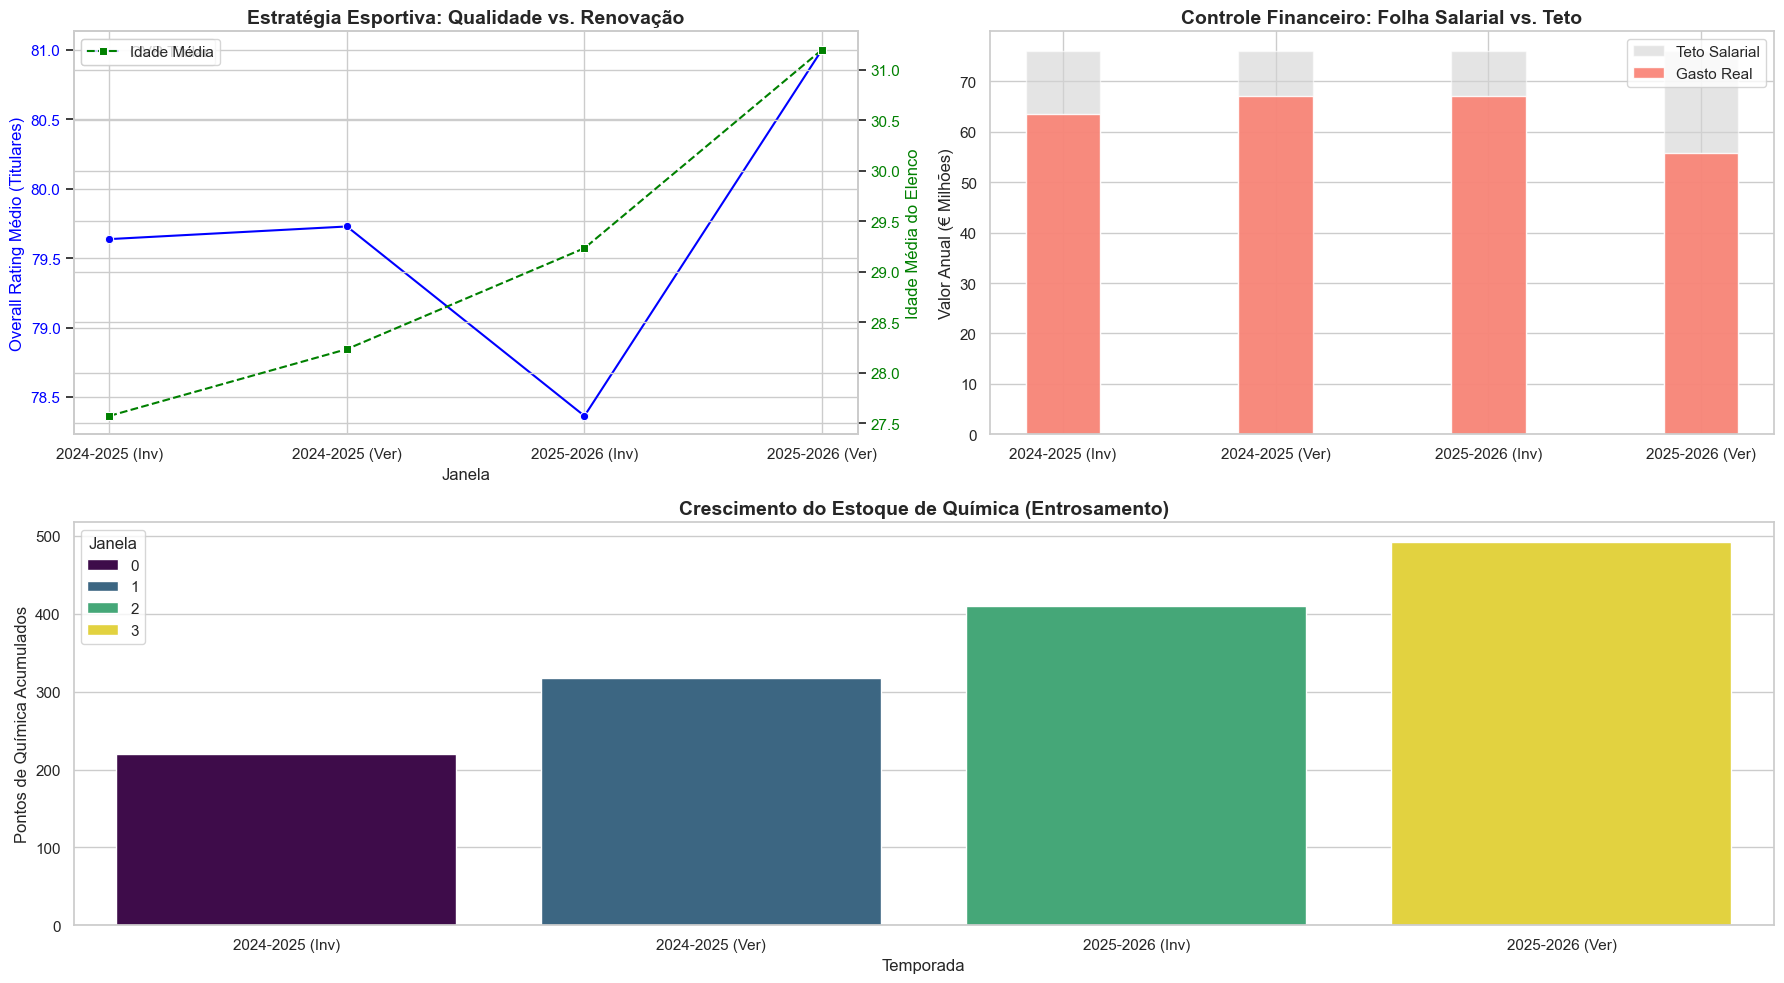

Gráficos gerados. Observe como a química (gráfico inferior) tende a crescer exponencialmente se o elenco for mantido.


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- [PIPELINE DE VISUALIZAÇÃO] ---

def gerar_graficos_resultados():
    if pulp.LpStatus[model.status] != 'Optimal' and pulp.LpStatus[model.status] != 'Undefined':
        print("O modelo não foi resolvido. Pule esta etapa.")
        return

    # 1. Extração de Dados do Solver para DataFrame
    dados_grafico = []
    
    for t in JANELAS:
        # Jogadores no elenco em t
        elenco_t_ids = [i for i in todos_os_ids 
                       if no_elenco_vars[i, t].varValue is not None and no_elenco_vars[i, t].varValue > 0.9]
        
        # Titulares em t
        titulares_t_ids = [i for i in todos_os_ids 
                          if titular_vars[i, t].varValue is not None and titular_vars[i, t].varValue > 0.9]
        
        # Estatísticas Agregadas
        ovr_medio_titular = np.mean([dados_temporais[i][t]['overall_rating'] for i in titulares_t_ids])
        idade_media = np.mean([dados_temporais[i][t]['age'] for i in elenco_t_ids])
        folha_salarial = sum([dados_temporais[i][t]['wage_eur'] * 52 for i in elenco_t_ids])
        
        # Química Total
        quimica_total = 0
        for (i, j) in pares_relevantes:
             if Quimica[(i, j, t)].varValue:
                 quimica_total += Quimica[(i, j, t)].varValue
        
        dados_grafico.append({
            'Janela': t,
            'Temporada': f"{2024 + t//2}-{2025 + t//2} ({'Inv' if t%2==0 else 'Ver'})",
            'OVR Titular': ovr_medio_titular,
            'Idade Média': idade_media,
            'Folha Salarial (€M)': folha_salarial,
            'Teto Salarial (€M)': WAGE_BUDGET_YEAR,
            'Química Total': quimica_total
        })
    
    df_res = pd.DataFrame(dados_grafico)

    # --- CONFIGURAÇÃO DO ESTILO ---
    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)

    # GRÁFICO 1: Evolução Técnica (Qualidade vs Idade)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.lineplot(data=df_res, x='Janela', y='OVR Titular', marker='o', color='blue', label='OVR Titular', ax=ax1)
    ax1.set_ylabel('Overall Rating Médio (Titulares)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    sns.lineplot(data=df_res, x='Janela', y='Idade Média', marker='s', color='green', linestyle='--', label='Idade Média', ax=ax2)
    ax2.set_ylabel('Idade Média do Elenco', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax1.set_title('Estratégia Esportiva: Qualidade vs. Renovação', fontsize=14, fontweight='bold')
    ax1.set_xticks(df_res['Janela'])
    ax1.set_xticklabels(df_res['Temporada'])

    # GRÁFICO 2: Saúde Financeira
    ax3 = fig.add_subplot(gs[0, 1])
    
    # Plotando Teto e Gasto
    bar_width = 0.35
    index = df_res['Janela']
    
    ax3.bar(index, df_res['Teto Salarial (€M)'], bar_width, label='Teto Salarial', color='lightgray', alpha=0.6)
    ax3.bar(index, df_res['Folha Salarial (€M)'], bar_width, label='Gasto Real', color='salmon', alpha=0.9)
    
    ax3.set_title('Controle Financeiro: Folha Salarial vs. Teto', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Valor Anual (€ Milhões)')
    ax3.set_xticks(index)
    ax3.set_xticklabels(df_res['Temporada'])
    ax3.legend()

    # GRÁFICO 3: Evolução da Química
    ax4 = fig.add_subplot(gs[1, :]) # Ocupa a largura inteira embaixo
    sns.barplot(data=df_res, x='Temporada', y='Química Total', hue='Janela', palette='viridis', ax=ax4)
    ax4.set_title('Crescimento do Estoque de Química (Entrosamento)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Pontos de Química Acumulados')
    
    plt.tight_layout()
    plt.show()
    
    print("Gráficos gerados. Observe como a química (gráfico inferior) tende a crescer exponencialmente se o elenco for mantido.")

# Chama a função
gerar_graficos_resultados()

## 5. Discussão e Conclusão

O modelo desenvolvido foi capaz de gerar um plano de gestão de elenco coerente, respeitando restrições financeiras complexas e táticas. No entanto, como toda modelagem matemática, existem simplificações que devem ser consideradas:

### 5.1. Limitações do Modelo

* **Determinismo:** O modelo assume que os jogadores evoluirão exatamente conforme as curvas projetadas. Na realidade, lesões ou má fase são fatores estocásticos imprevisíveis. Uma abordagem via **Programação Estocástica** seria mais robusta.

* **Linearidade da Performance:** Assumimos que a força do time é a soma das habilidades individuais + química de pares. O futebol real possui dinâmicas não-lineares complexas.

* **Complexidade Computacional:** A inclusão da variável de Química ($Q_{i,j,t}$) cria uma dependência quadrática ($O(N^2)$). Para contornar isso, utilizamos técnicas de "poda" (selecionando apenas os pares mais relevantes), mas para bases de dados maiores, heurísticas como **Meta-heurísticas (Algoritmo Genético)** poderiam ser necessárias.

### 5.2. Trabalhos Futuros
Para expandir este projeto, sugerem-se as seguintes melhorias:

1.  Incluir restrições de **jogadores estrangeiros** (comuns no Brasil e Europa).

2.  Modelar a **probabilidade de lesão** baseada no atributo "Physical".

3.  Implementar uma interface visual para que um diretor de futebol pudesse simular cenários ("E se o orçamento cair pela metade?").
